# Amplitude, phase and power spectra of magnetic data

This code illustrates the amplitude, phase and power spectra of magnetic data produced by homogeneous rectangular prisms.

### Things we have to import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from gravmag.models import rectangular_prism as rp
from gravmag import plot_functions as plf

In [3]:
from gravmag import filters, convolve, transforms

### Model

In [4]:
# Create a model formed by prisms
model = np.array([[2000., 3000., -1500., -500., 10., 1010.], 
                  [1600., 2600., -2500., -1500., 10., 1010.], 
                  [-1000., 1000., 1500, 2500, 10., 1010.],
                  [-3000., -2000., -35000, 35000., 10., 1010.]])

# magnetization of each prism
# first, second and third columns contain
# the magnetization intensity (in A/m), inclination 
# and declination (in degrees) of the sources
inc, dec = 3, -45
magnetization = np.array([[1.4, inc, dec],
                          [1.3, inc, dec],
                          [1.1, inc, dec],
                          [1.2, inc, dec]])

# Components of the unit vector defining the
# total-magnetization direction
cos_inc = np.cos(np.deg2rad(inc))
sin_inc = np.sin(np.deg2rad(inc))
cos_dec = np.cos(np.deg2rad(dec))
sin_dec = np.sin(np.deg2rad(dec))
hx_hat = cos_inc*cos_dec
hy_hat = cos_inc*sin_dec
hz_hat = sin_inc

### Points were we compute the synthetic data

In [5]:
# number of points along x and y
shape = (60, 60)

# minimum x, maximum x, minimum y and maximum y
area = [-5000, 5000, -4000, 6000]

# Grid spacing
dx = (area[1] - area[0])/(shape[0]-1)
dy = (area[3] - area[2])/(shape[1]-1)

# coordinates 
xp = np.linspace(area[0], area[1], shape[0])
yp = np.linspace(area[2], area[3], shape[1])
yp, xp = np.meshgrid(yp, xp)
yp = np.ravel(yp)
xp = np.ravel(xp)
#zp = np.zeros_like(yp) - 150
zp = np.zeros_like(yp) + 300

coordinates = np.vstack([xp, yp, zp])

In [6]:
print(dx, dy)

169.4915254237288 169.4915254237288


### Main field

In [7]:
# reference point
yc, xc = 0, 1000

# inclination (degrees)
I0 = -26 - 1e-4*(xp-xc) + 3e-4*(yp-yc) + 1e-8*(xp-xc)*(xp-xc) + 1e-8*(yp-yc)*(yp-yc)

# declination (degrees)
D0 = 20 + 6e-5*(xp-xc) + 1e-4*(yp-yc) + 3e-9*(xp-xc)*(xp-xc) + 4e-9*(yp-yc)*(yp-yc)

# intensity (nT)
F0 = 23400 + 1e-4*(xp-xc) + 1e-4*(yp-yc) + 0*(xp-xc)*(xp-xc) + 0*(yp-yc)*(yp-yc)

# Cartesian components of the main field
cosI0 = np.cos(np.deg2rad(I0))
sinI0 = np.sin(np.deg2rad(I0))
cosD0 = np.cos(np.deg2rad(D0))
sinD0 = np.sin(np.deg2rad(D0))
Fx = F0*cosI0*cosD0
Fy = F0*cosI0*sinD0
Fz = F0*sinI0

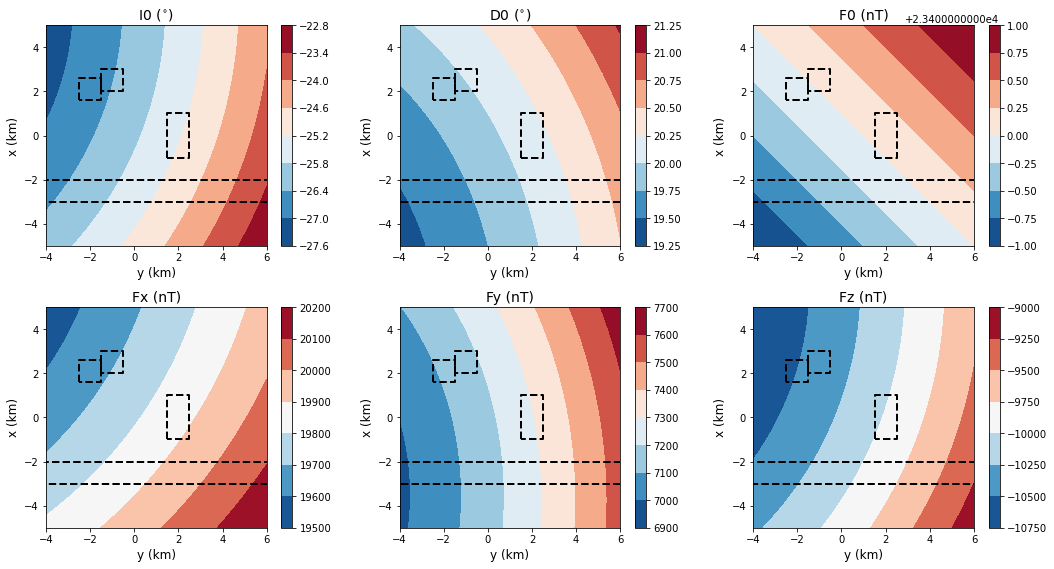

In [8]:
fields = [I0, D0, F0, Fx, Fy, Fz]
windows = [1, 2, 3, 4, 5, 6]
titles = ['I0 ($^{\circ}$)', 'D0 ($^{\circ}$)', 'F0 (nT)',
          'Fx (nT)', 'Fy (nT)', 'Fz (nT)']

plt.figure(figsize=(15,8))

for w, window in enumerate(windows):

    plt.subplot(2,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(yp.reshape(shape)*0.001, 
                 xp.reshape(shape)*0.001, 
                 fields[w].reshape(shape), cmap='RdBu_r')
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*area[0], 0.001*area[1])
    plt.xlim(0.001*area[2], 0.001*area[3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

In [9]:
# Compute the average direction of the main field
mean_I0 = np.mean(I0)
mean_D0 = np.mean(D0)
cos_mean_I0 = np.cos(np.deg2rad(mean_I0))
sin_mean_I0 = np.sin(np.deg2rad(mean_I0))
cos_mean_D0 = np.cos(np.deg2rad(mean_D0))
sin_mean_D0 = np.sin(np.deg2rad(mean_D0))
Fx_hat = cos_mean_I0*cos_mean_D0
Fy_hat = cos_mean_I0*sin_mean_D0
Fz_hat = sin_mean_I0

In [10]:
print(mean_I0, mean_D0)

-25.407683615819206 20.107310734463276


### Synthetic residual field

In [11]:
# Compute the magnetic field components
bx = rp.mag(coordinates=coordinates, prisms=model, magnetization=magnetization, field='b_x')
by = rp.mag(coordinates=coordinates, prisms=model, magnetization=magnetization, field='b_y')
bz = rp.mag(coordinates=coordinates, prisms=model, magnetization=magnetization, field='b_z')

# Add a noise to the synthetic data
bx += np.random.normal(loc=0, scale=5, size=bx.size)
by += np.random.normal(loc=0, scale=5, size=by.size)
bz += np.random.normal(loc=0, scale=5, size=bz.size)

# Compute the total-field anomaly
tfa = np.sqrt((Fx+bx)**2 + (Fy+by)**2 + (Fz+bz)**2) - F0

### Compute the amplitude spectrum

In [12]:
# 2D Fourier transform of the TFA with padding
FT_tfa = transforms.DFT(data=tfa.reshape(shape), pad_mode='constant')

# compute the wavenumbers
kx, ky, kz = transforms.wavenumbers(FT_tfa.shape, dx, dy)

In [13]:
# compute the amplitude, phase and power spectra
spectra_tfa = transforms.spectra(
    FT_data=FT_tfa, shift=False, types=['amplitude', 'phase', 'power'], check_input=False
)

### Plot the results

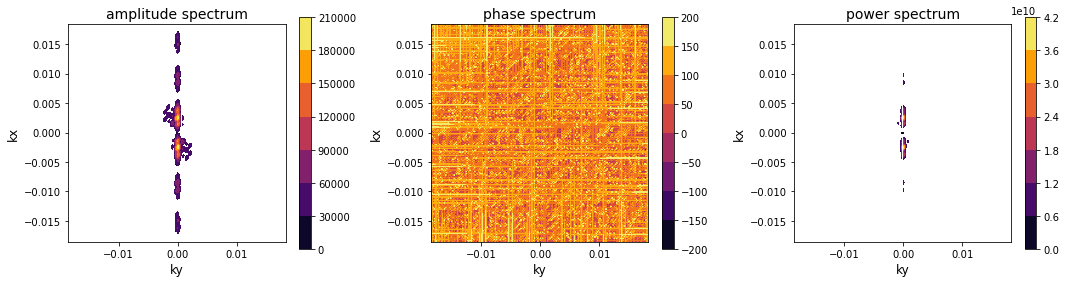

In [14]:
windows = [1, 2, 3]
titles = ['amplitude spectrum', 'phase spectrum', 'power spectrum']

plt.figure(figsize=(15,4))

for w, window in enumerate(windows):
    plt.subplot(1,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(
        ky, kx, spectra_tfa[w], cmap='inferno'
    )
    plt.colorbar()
    plt.ylim(np.min(kx), np.max(kx))
    plt.xlim(np.min(ky), np.max(ky))
    plt.xlabel('ky', fontsize=12)
    plt.ylabel('kx', fontsize=12)

plt.tight_layout()

plt.show()

### Filtering

In [15]:
np.min(spectra_tfa[0]), np.max(spectra_tfa[0])

(2.0583756973831715, 201222.51623376578)

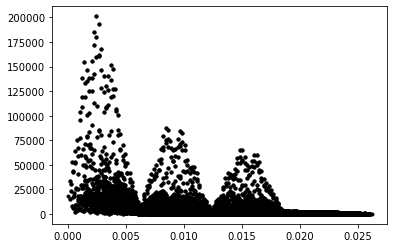

In [16]:
plt.figure()
plt.plot(kz.ravel(), spectra_tfa[0].ravel(), 'k.')
plt.show()

In [17]:
cuttoff_frequencies = [0.005, 0.010, 0.015, 0.020]

FT_filtered_tfa = []

for cuttoff_k in cuttoff_frequencies:
    # define the filter
    cuttoff_filter = filters.cuttof_frequency(kz=kz, max_freq=cuttoff_k)
    # convolve data in Fourier domain
    FT_filtered_tfa.append(convolve.compute(FT_data=FT_tfa, filters=[cuttoff_filter]))

In [18]:
filtered_tfa = []

for filtered_data in FT_filtered_tfa:
    # transform convolved data to space domain
    filtered_tfa.append(transforms.IDFT(FT_data=filtered_data, unpad=True, grid=False))

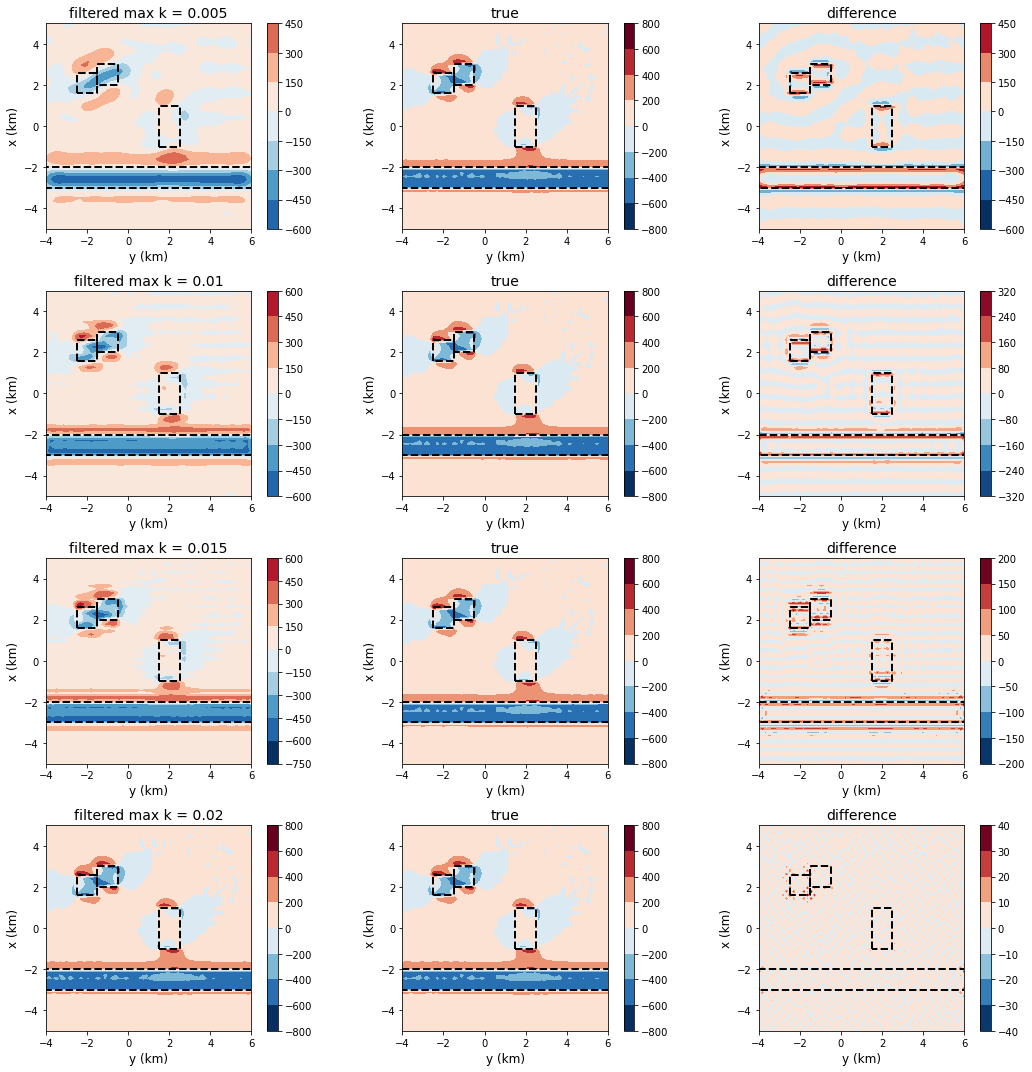

In [19]:
true_fields = [tfa, tfa, tfa, tfa]

bounds, diffs = plf.bounds_diffs(filtered_tfa, true_fields)

fields = plf.fields_list(filtered_tfa, true_fields, diffs)

titles = []
for cuttoff_k in cuttoff_frequencies:
    titles.append('filtered max k = {}'.format(cuttoff_k))
    titles.append('true')
    titles.append('difference')

windows = [i for i in range(1,13)]

plt.figure(figsize=(15,15))

for w, window in enumerate(windows):

    plt.subplot(4,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(
        yp.reshape(shape)*0.001, 
        xp.reshape(shape)*0.001, 
        fields[w].reshape(shape), 
        cmap='RdBu_r',
        vmin = -bounds[w], vmax = bounds[w]
    )
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*area[0], 0.001*area[1])
    plt.xlim(0.001*area[2], 0.001*area[3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()